# Assignment 3


In this assignment, you will convert GAN and VAE implementations into Conditional GAN and Conditional VAE, respectively: 

Grading:
- Conditional GAN (35 points):
  - Data preprocessing (10 points)
  - Discriminator and Generator (15 points)
  - Training (10 points)
- Conditional VAE (35 points):
  - Data preprocessing (10 points)
  - Encoder and Decoder (15 points)
  - Training (10 points)
- Comparison (15 points):
  - Conditional GAN image generation (5 points)
  - Conditional VAE image generation (5 points)
  - Your opinion which results are better (5 points)
- Metrics and training plots (10 points)
- Clean and documented code (5 points)


Remarks: 

*   Use Fashion MNIST dataset
*   Use Pytorch
*   Cheating will result in 0 points

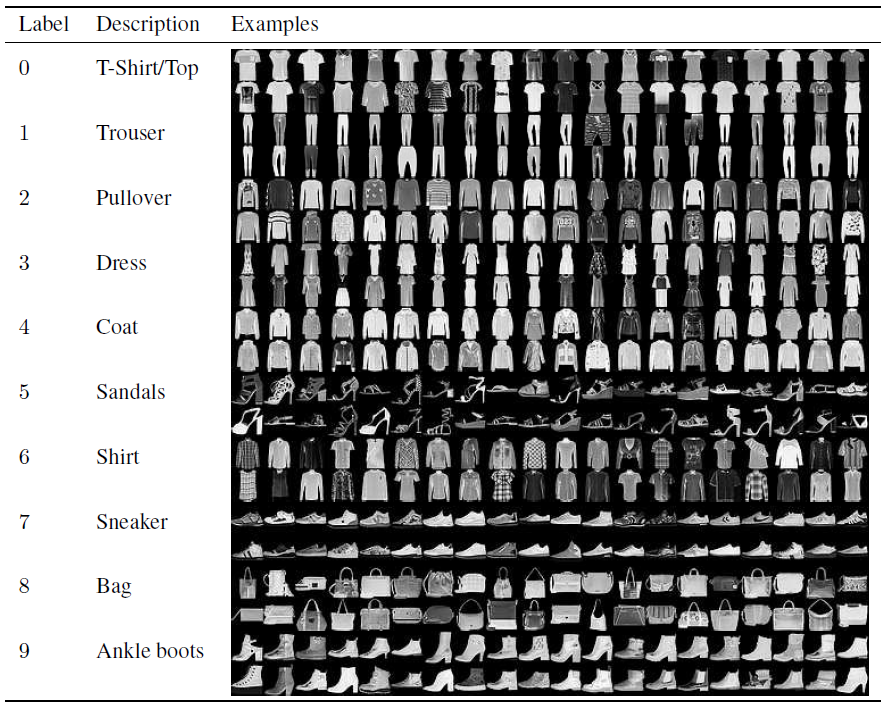

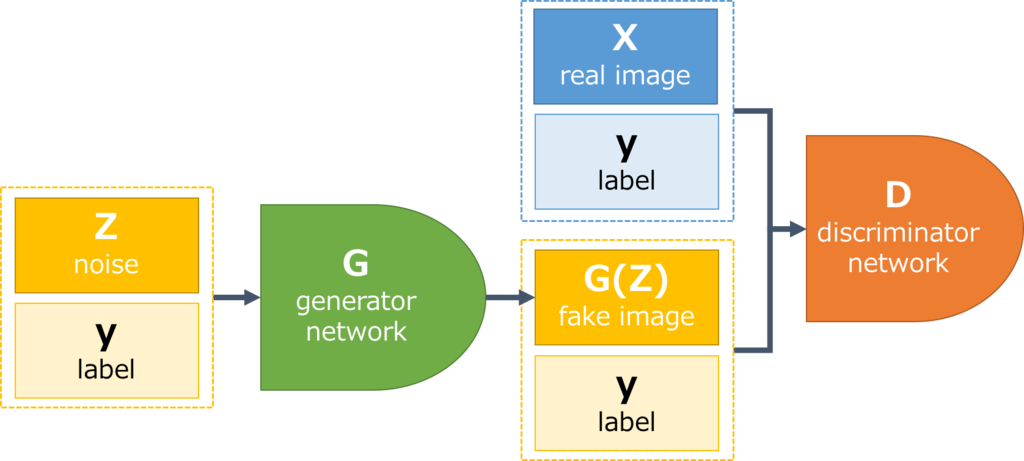

# Conditional GAN
Change this GAN implementation from Lab 11 into Conditional GAN

In [6]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

c:\Users\datapaf\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data
Use Fashion MNIST dataset

In [8]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# make transform to convert data to tensor and add channel dimension
transform = transforms.ToTensor()

# download training dataset
trainset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [9]:
# check the size of the dataset
trainset.data.shape

torch.Size([60000, 28, 28])

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# create data loader
train_loader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [11]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

## Discriminator

In [61]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization."""
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    # append conv layer
    layers.append(conv_layer)
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    # using Sequential container return the layers
    return nn.Sequential(*layers)


class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # first conv layer
        # input: 1 channel image + 1 channel vector
        # output: conv_dim channels
        self.layer1 = conv(2, conv_dim, 4, batch_norm=False)

        # sencond conv layer
        # input: conv_dim channels
        # output: 2*conv_dim channels
        self.layer2 = conv(conv_dim, conv_dim*2, 4)

        # third conv layer
        # input: 2*conv_dim channels
        # output: 4*conv_dim channels
        self.layer3 = conv(conv_dim*2, conv_dim*4, 4)

        # leaky relu for all layers
        self.relu = nn.LeakyReLU()

        # final fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

        # embedding layer for labels
        self.embed = nn.Embedding(10, 50)

        # fully-connected layer to project vectors to 28*28 
        self.fc2 = nn.Linear(50, 28*28)

    def forward(self, images, labels):

        # pass image through embedding layer
        vec = self.embed(labels)
        # pass vec through fully connected layer with 28*28 output
        vec = self.fc2(vec)
        # reshape vec to be size (batch_size, 1, 28, 28)
        vec_2d = vec.view(-1, 1, 28, 28)

        # concatenate images and vec_2d
        x = torch.cat((images, vec_2d), 1)

        # hidden layers + leaky relu activation 
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        out = self.relu(self.layer3(out))
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)
               
        return out

## Generator

In [62]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization. """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        # project z_size vector into conv_dim*4*4*4 vector
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # embedding layer for labels
        self.embed = nn.Embedding(10, 50)

        # fully-connected layer to project label embedding
        self.fc2 = nn.Linear(50, 4*4)

        # create deconv layer input conv_dim*4 + 1 output conv_dim*2
        self.layer1 = deconv(conv_dim*4 + 1, conv_dim*2, 4)

        # create deconv layer input conv_dim * 2 output conv_dim 
        self.layer2 = deconv(conv_dim*2, conv_dim, 4)

        # create deconv layer input conv_dim  output 1
        self.layer3 = deconv(
            in_channels=conv_dim,
            out_channels=1,
            kernel_size=4,
            padding=3
        )

        # activations
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()


    def forward(self, noises, labels):
        
        # project z_size noise vector into conv_dim*4*4*4 vector
        noises = self.fc(noises)

        # reshape noises to be (batch_size, conv_dim*4, 4, 4)
        noises_2d = noises.view(-1, self.conv_dim*4, 4, 4) 
        
        # pass labels through embedding layer
        vec = self.embed(labels)
        # pass vec through fully connected layer with 4*4 output
        vec = self.fc2(vec)
        # reshape vec to be size (batch_size, 1, 4, 4)
        vec_2d = vec.view(-1, 1, 4, 4)

        # concatenate noises_2d and vec_2d
        x = torch.cat((noises_2d, vec_2d), 1)

        # 2 hidden transpose conv layers + relu
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        
        # last layer deconv  + tanh activation
        out = self.tanh(self.layer3(out))
        
        return out
    

## Training

In [80]:
import torch.optim as optim
#import pickle as pkl

# define params
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

# print(D)
# print()
# print(G)

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    


# hyperparams
lr = 0.0002
beta1=0.5
beta2=0.999 # default value
num_epochs = 5

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

GPU available for training. Models moved to GPU


In [81]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [82]:
for epoch in range(num_epochs):
    
    d_epoch_loss = 0
    g_epoch_loss = 0

    for batch_i, (real_images, labels) in enumerate(train_loader):
        
        # load labels to GPU if available
        if train_on_gpu:
            labels = labels.cuda()

        # get batch size
        batch_size = real_images.size(0)
        
        # rescale images to be between -1 and 1
        real_images = scale(real_images)
        
        # load images to GPU if available
        if train_on_gpu:
            real_images = real_images.cuda()
        
        # --------------- TRAIN THE DISCRIMINATOR ---------------
         
        d_optimizer.zero_grad()

        # 1. Train with real images
        # Compute the discriminator losses on real images 
        d_real_loss = real_loss(D(real_images, labels), smooth=True)
       
        
        # 2. Train with fake images
        # generate random noise and load to GPU if available
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        
        # generate fake images and compute the discriminator losses
        d_fake_loss = fake_loss(D(G(z, labels), labels))

        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # --------------- TRAIN THE GENERATOR ---------------

        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
    
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z, labels)
        
        # Compute the discriminator losses on fake images using flipped labels
        g_loss = real_loss(D(fake_images, labels))
  
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        d_epoch_loss += d_loss.item()
        g_epoch_loss += g_loss.item()

    d_epoch_loss = d_epoch_loss/len(train_loader)
    g_epoch_loss = g_epoch_loss/len(train_loader)
    
    # append discriminator loss and generator loss
    losses.append((d_epoch_loss, g_epoch_loss))
    # print discriminator and generator loss
    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

Epoch [    1/    5] | d_loss: 0.3423 | g_loss: 5.0078
Epoch [    2/    5] | d_loss: 0.3468 | g_loss: 5.2186
Epoch [    3/    5] | d_loss: 0.3468 | g_loss: 5.4723
Epoch [    4/    5] | d_loss: 0.4136 | g_loss: 3.7529
Epoch [    5/    5] | d_loss: 0.3724 | g_loss: 4.5081


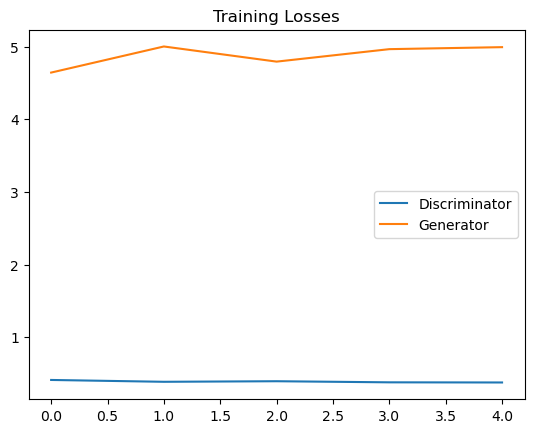

In [83]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

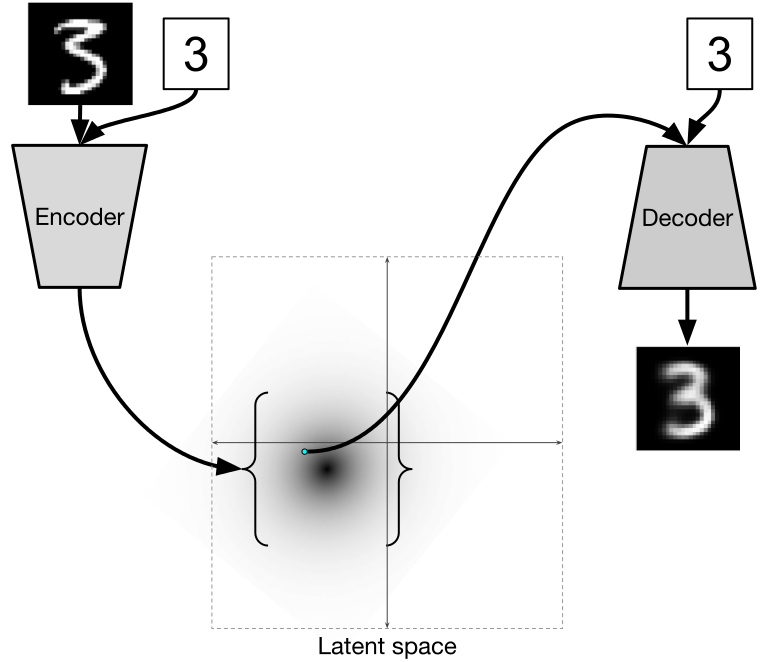

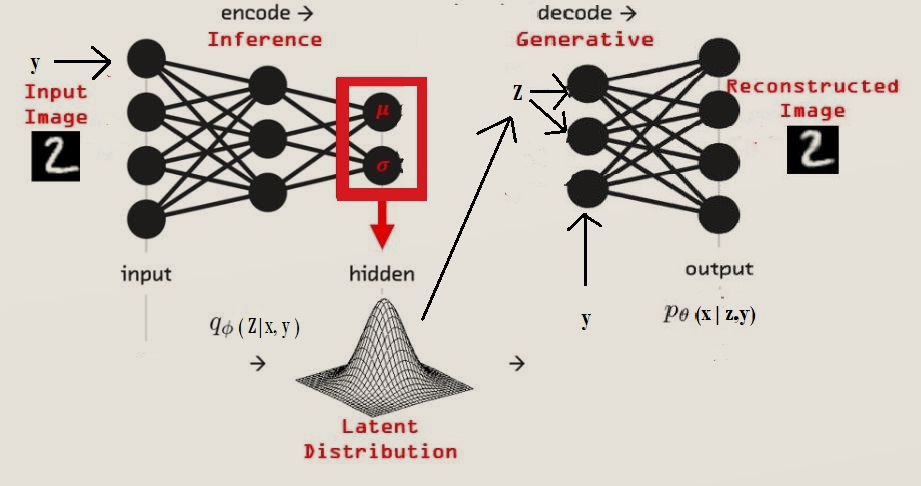

# Conditional Variational Autoencoder

Change this VAE implementation into Conditional VAE 

## Data

## Encoder

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

## Training

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():
    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

# Comparison
Generate images of given labels using both Conditional GAN and Conditional VAE models that you trained. Write your opinion which model is better.

## Conditional GAN
Generate two images of each class from Fashion MNIST dataset using your Conditional GAN model

In [125]:
z = np.random.uniform(-1, 1, size=(20, z_size))
z = torch.from_numpy(z).float()
if train_on_gpu:
    z = z.cuda()

In [126]:
# make labels
labels = np.array([num % 10 for num in range(20)])
labels = torch.from_numpy(labels)
if train_on_gpu:
    labels = labels.cuda()

In [127]:
output_tensor = G(z, labels).cpu().detach().numpy()
output_tensor.shape

(20, 1, 28, 28)

In [128]:
label_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

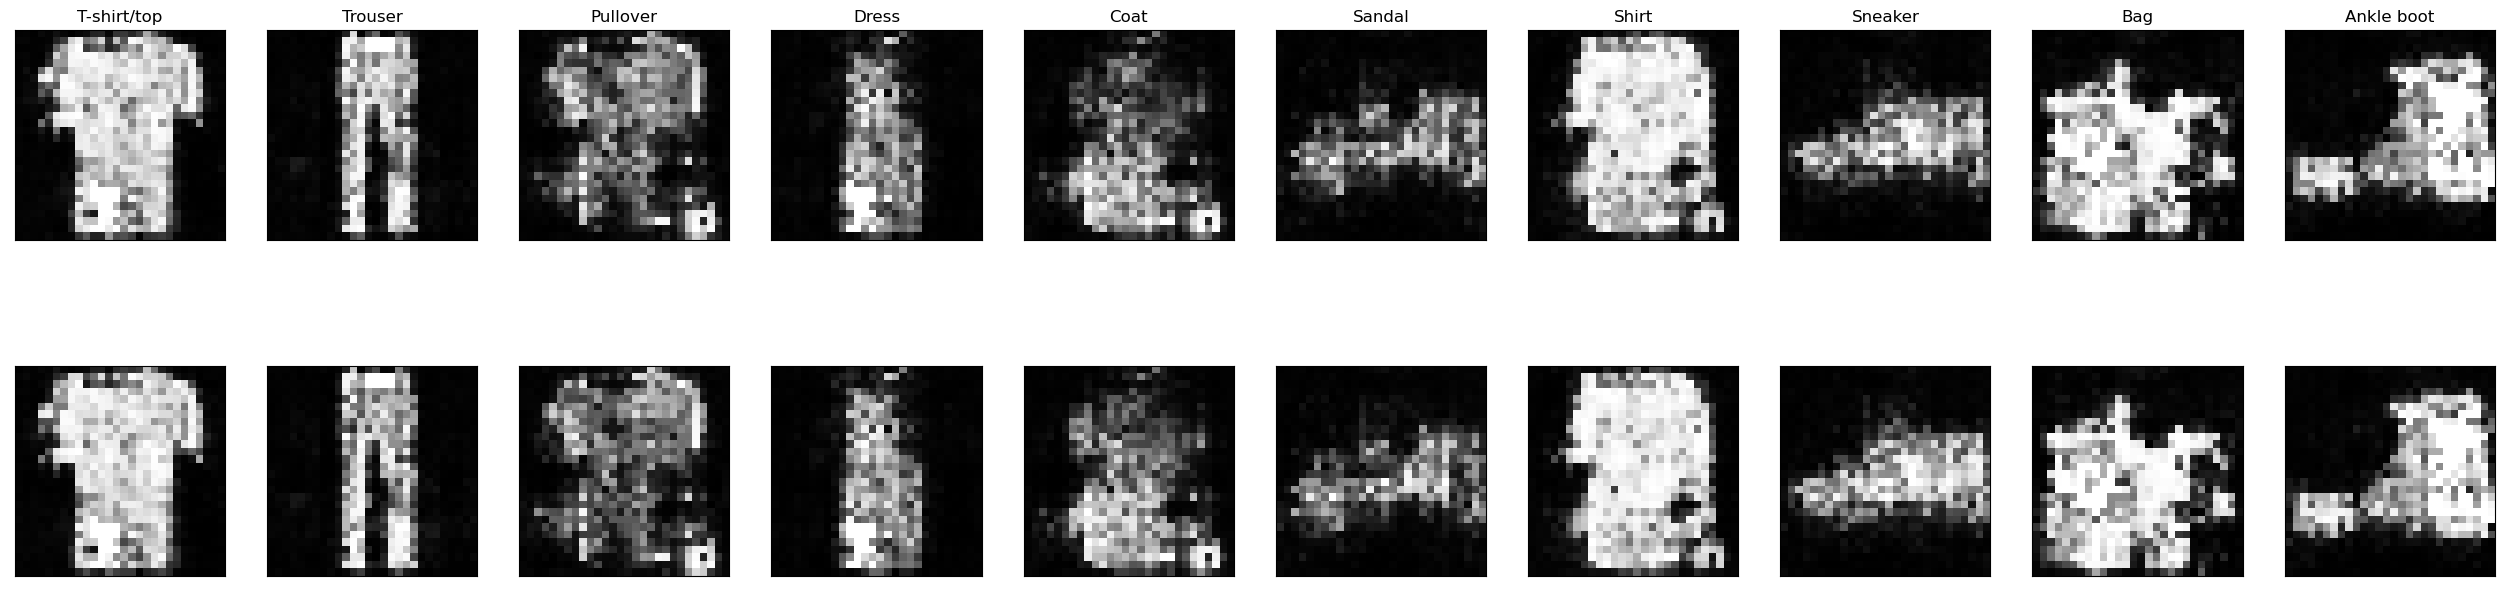

In [129]:
fig, axes = plt.subplots(figsize=(32,8), nrows=2, ncols=10)
for i, ax in enumerate(axes.flatten()):
    img = output_tensor[i]
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if i < 10:
        ax.set_title(label_name[i])
    
plt.show()

## Conditional VAE
Generate two images of each class from Fashion MNIST dataset using your Conditional VAE model

## Your opinion
Write your opinion which model is better.

# References

* [Synthetic Data Generation Using Conditional-GAN](https://towardsdatascience.com/synthetic-data-generation-using-conditional-gan-45f91542ec6b)

* [Generating synthetic tabular data with GANs](https://medium.com/ydata-ai/generating-synthetic-tabular-data-with-gans-part-2-a0aba150539)

* [Understanding Conditional Variational Autoencoders](https://theaiacademy.blogspot.com/2020/05/understanding-conditional-variational.html)

* [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

* [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

* [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

* [The variational auto-encoder](https://ermongroup.github.io/cs228-notes/extras/vae/)

* [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)

* [Basic VAE Example](https://github.com/pytorch/examples/tree/master/vae)

* [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)

* [Generative adversarial networks: What GANs are and how they’ve evolved](https://venturebeat.com/2019/12/26/gan-generative-adversarial-network-explainer-ai-machine-learning/)

* [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

* [GANs by google](https://developers.google.com/machine-learning/gan)

* [A Gentle Introduction to Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

* [A Beginner's Guide to Generative Adversarial Networks (GANs)](https://pathmind.com/wiki/generative-adversarial-network-gan)

* [Understanding Generative Adversarial Networks (GANs)](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

* [Deep Learning (PyTorch)](https://github.com/udacity/deep-learning-v2-pytorch)

* [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)

* [GAN(Generative Adversarial Networks) и tensorflow (Russian)](https://habr.com/ru/post/332000/)

* [Conditional VAE (Russian)](https://habr.com/ru/post/331664/)